# Biodiversity Intactness Index change in Phoenix, AZ

Author: Josephine Cardelle

[Github repository](https://github.com/jocardelle/biodiversity-intactness-index)

## About

### Purpose
Due to a rapid increase in developed land, Phoenix, Arizona has seen changes in biodiversity. In this project I investigate the impacts of the increase on biodiversity by analyzing the changes in Biodiversity Intactness Index(BII).

### Highlights
- Searching for data using the Microsoft Planetary Computer’s(MPC) STAC API
- Clipping large raster to detailed geometry using `rio.clip()`
- Map making using '`matplotlib`

### About the data
The first dataset is the Biodiversity Intactness Index(BII) Time Series. This data comes from the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). In the analysis we use the 2017 and 2020 rasters.

The second dataset is the [Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2024&layergroup=County+Subdivisions) County Subdivisions shapefile for Arizona. The Phoenix subdivision was downloaded from this shapefile.

### References
1. Microsoft Planetary Computer. (n.d.). IO biodiversity dataset. Retrieved December 3, 2024, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

2. U.S. Census Bureau. (2024). Arizona county subdivisions: tl_2024_04_cousub.shp [Shapefile dataset]. Retrieved from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2024&layergroup=County+Subdivisions 

## Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch # To manually add legends
import geopandas as gpd
import rioxarray as rioxr
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

## Read in data

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:
# Import arizona data
fp = os.path.join('data','tl_2024_04_cousub','tl_2024_04_cousub.shp')
az = gpd.read_file(fp)

## Data exploration

Here we are going to explore the two datasets to familiarize ourselves.

In [24]:
# View the io-biodiversity collection
catalog.get_child('io-biodiversity')

<CollectionClient id=io-biodiversity>

In [5]:
# Create bounding box for search
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]
# Create time range for search
time_range = "2017-01-01/2020-01-01"
# Search MPC catalog 
search = catalog.search(collections=["io-biodiversity"], bbox=bbox_of_interest, datetime = time_range)

In [6]:
# Retrieve search items
items = search.item_collection()
len(items)

4

In [7]:
# Look at properties of each items to view the date ranges
items

In [8]:
# Select unique search item
item_20 = items[0]
item_17 = items[3]

In [9]:
# View the properties of the item to view the projection
print('id:' , item_17.id)
item_17.properties

id: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z'}

In [10]:
# View the properties of the item to view the projection
print('id:' , item_20.id)
item_20.properties

id: bii_2020_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2020-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2020-01-01T00:00:00Z'}

In [11]:
# Check assets in each item
for key in item_17.assets.keys():
    print(key, '--', item_17.assets[key].title)
    
    
for key in item_20.assets.keys():
    print(key, '--', item_20.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview
data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


The exploration of the MPC STAC catalog gave lots of information. First, I viewed the `io-biodiversity` collection and was able to obtain its description, temporal extent, spatial extent and more. The temporal extent was `2017-01-01T00:00:00Z -  2020-12-31T23:59:59Z` and the spatial extent was `[-180, -90, 180, 90]`. I then searched the catalog for the collection, date range, and area of interest and found there were 4 items that matched the search. After viewing the 4 items I chose the two of interest, for years 2017 and 2020. We then used `.properties` to find the projection of each item which was EPSG 4326, and utilizes `.assets.keys()` to check the assets in each item. 

In [12]:
# View the size of the arizona df
az.shape

(80, 17)

In [13]:
# View the columns of the arizona df
az.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."


In [14]:
# Filter arizona df to Phoenix subdivision
phx = az[az['NAME'] == "Phoenix"]
phx.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
10,04,013,92601,01934968,0401392601,0600000US0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,S,2806483087,9458600,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


By exploring the shape of the Arizona df I found there were 80 rows and 17 columns. I then viewed the first three rows of the df. After this I was able to use the column names to filter the df to just the Phoenix subdivision. I viewed the new Phoenix df to ensure only Phoenix was present, and one row matched the filter.

## Phoenix, AZ Map

Create a map showing where Phoenix is located in Arizona.

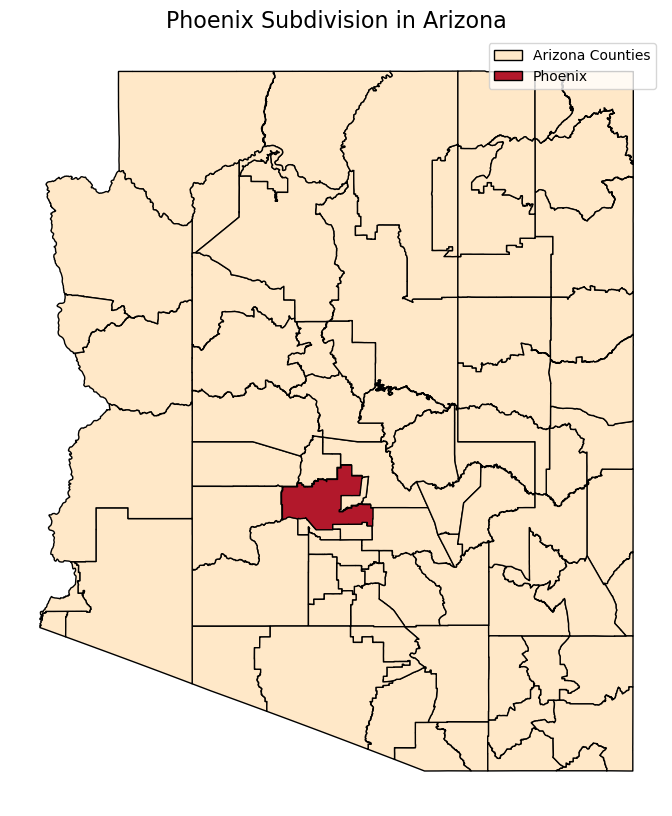

In [15]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.axis('off')

az.plot(ax = ax, facecolor = "#ffe8c8", edgecolor = "Black", label = "Arizona Counties") # Map Arizona df with all counties

phx.plot(ax = ax, facecolor = "#b2182b", edgecolor = "Black", label = "Phoenix") # Map Phoenix subdivision

plt.title('Phoenix Subdivision in Arizona', fontsize = 16)

legend = [Patch(facecolor = '#ffe8c8', edgecolor = 'black', label = 'Arizona Counties'), Patch(facecolor = '#b2182b', edgecolor = 'black', label = 'Phoenix')] # Manually add legend

ax.legend(handles=legend)

plt.savefig('images/phoenix_arizona_map.png') # Save map in images folder
plt.show()

## Biodiversity Intactness Index in Phoenix

I want to find the percent area in Phoenix with a BII greater than or equal to 0.75 in the years 2017 and 2020.

In [27]:
# Open the raster data
bii17 = rioxr.open_rasterio(item_17.assets['data'].href)
bii20 = rioxr.open_rasterio(item_20.assets['data'].href)

In [17]:
# Clip the bii rasters to phoenix
bii17_phx = bii17.rio.clip(phx['geometry'])
bii20_phx = bii20.rio.clip(phx['geometry'])

In [18]:
# Find areas where bii >= 0.75 and assign 1 to true and 0 to false
bii17_high = (bii17_phx >= 0.75).astype('int')
bii20_high = (bii20_phx >= 0.75).astype('int')

In [19]:
# Find total number of pixels for each year
total_pix_17 = bii17_phx.count().item()
total_pix_20 = bii20_phx.count().item()

In [20]:
# Find count of pixels above 0.75 bii for each year
bii_pix_17 = bii17_high.values.sum()
bii_pix_20 = bii20_high.values.sum()

In [28]:
# Calculate percentages
bii_pct17 = (bii_pix_17 / total_pix_17) * 100
bii_pct20 = (bii_pix_20 / total_pix_20) * 100

print(f"In 2017, {round(bii_pct17, 2)}% of the Phoenix subdivision had a BII of at least 0.75" )
print(f"In 2020, {round(bii_pct20, 2)}% of the Phoenix subdivision had a BII of at least 0.75" )

In 2017, 7.13% of the Phoenix subdivision had a BII of at least 0.75
In 2020, 6.49% of the Phoenix subdivision had a BII of at least 0.75


## BII lost from 2017 to 2020

There was a higher percent of area in Phoenix with a BII of at least 0.75 in 2017 than in 2020. I want to find the areas that fell below this threshold between the two years.

In [22]:
# Calculate difference in pixels above 0.75 from 2017 to 2020
diff_17_20 = bii17_high - bii20_high

# Set all that are not 1 to na
loss_17_20 = diff_17_20.where(diff_17_20 == 1)

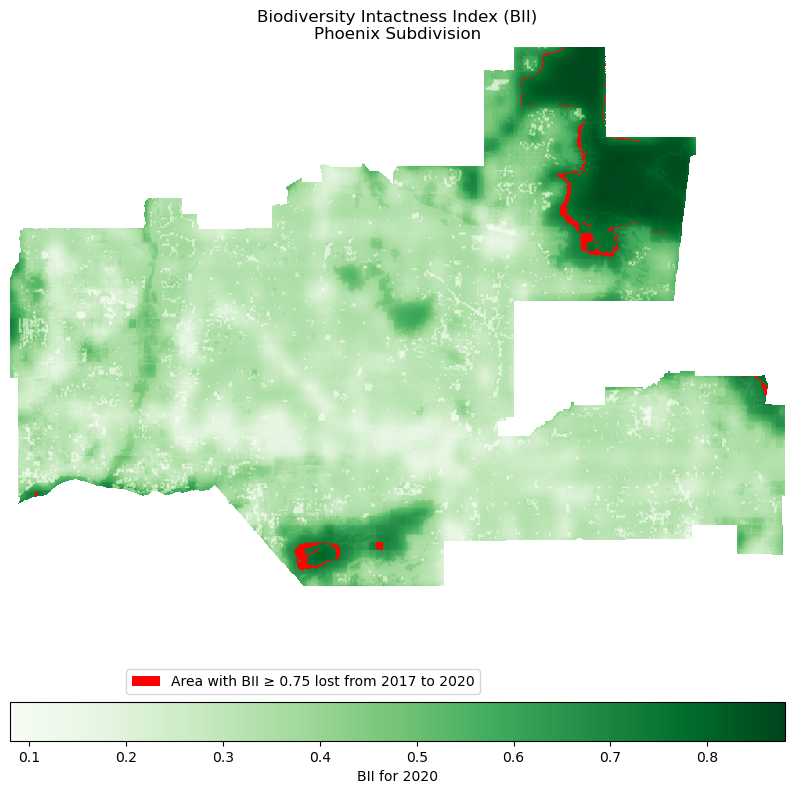

In [31]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.axis('off')

bii20_phx.plot(ax=ax, cmap = 'Greens', cbar_kwargs={'orientation':'horizontal', 'label':'BII for 2020'})

loss_17_20.plot(ax=ax, cmap = 'brg', add_colorbar = False)

legend = [Patch(facecolor = 'red', label = 'Area with BII ≥ 0.75 lost from 2017 to 2020')]

ax.legend(handles=legend, loc=(0.15, -0.2))

ax.set_title("Biodiversity Intactness Index (BII)\nPhoenix Subdivision")

plt.savefig('images/bii_phoenix.png')
plt.show()